# Logistic Regression - Bank Marketing Campaign Prediction

**Objective:** Build a Logistic Regression model to predict term deposit subscription.

**Algorithm:** Logistic Regression - A linear model for binary classification that estimates probabilities using the logistic function.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load and Explore Data

In [2]:
# Load dataset
df = pd.read_csv('../bank-additional-full.csv', sep=';')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (41188, 21)

Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Data info and missing values
print("Data Info:")
print(df.info())

print("\n" + "="*60)
print("Missing Values:")
print(df.isnull().sum())

print("\n" + "="*60)
print("Duplicates:", df.duplicated().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4118

In [4]:
# Remove duplicates
df_clean = df.drop_duplicates()
print(f"Shape after removing duplicates: {df_clean.shape}")

# Statistical summary
df_clean.describe()

Shape after removing duplicates: (41176, 21)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## 3. Target Variable Analysis

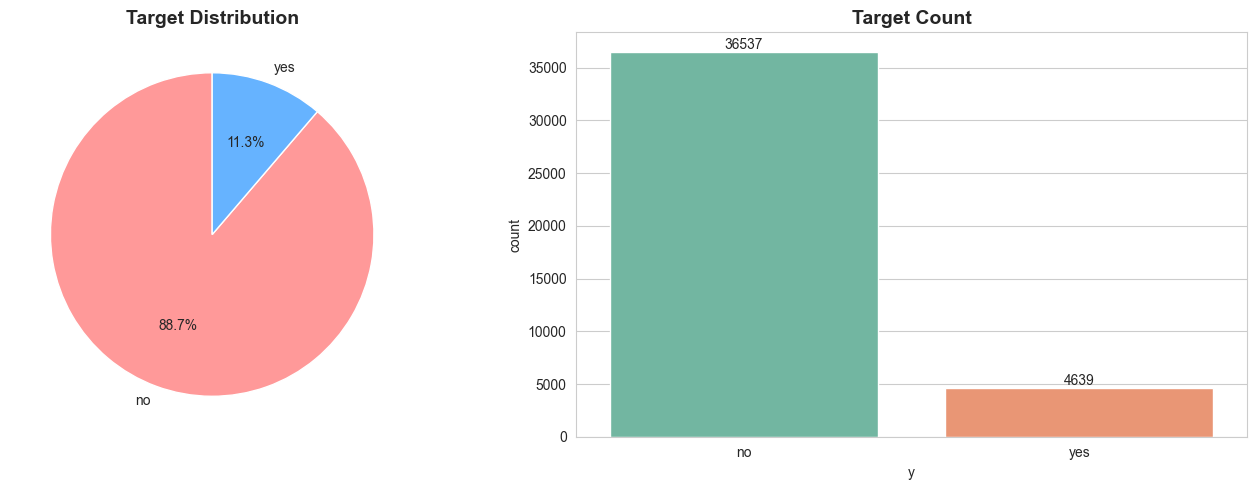

Class Distribution:
y
no     36537
yes     4639
Name: count, dtype: int64

Class Ratio:
y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64


In [5]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
target_counts = df_clean['y'].value_counts()
axes[0].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=['#ff9999', '#66b3ff'])
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')

# Bar chart
sns.countplot(data=df_clean, x='y', palette='Set2', ax=axes[1])
axes[1].set_title('Target Count', fontsize=14, fontweight='bold')
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()

print(f"Class Distribution:\n{df_clean['y'].value_counts()}")
print(f"\nClass Ratio:\n{df_clean['y'].value_counts(normalize=True)}")

## 4. Key Feature Visualizations

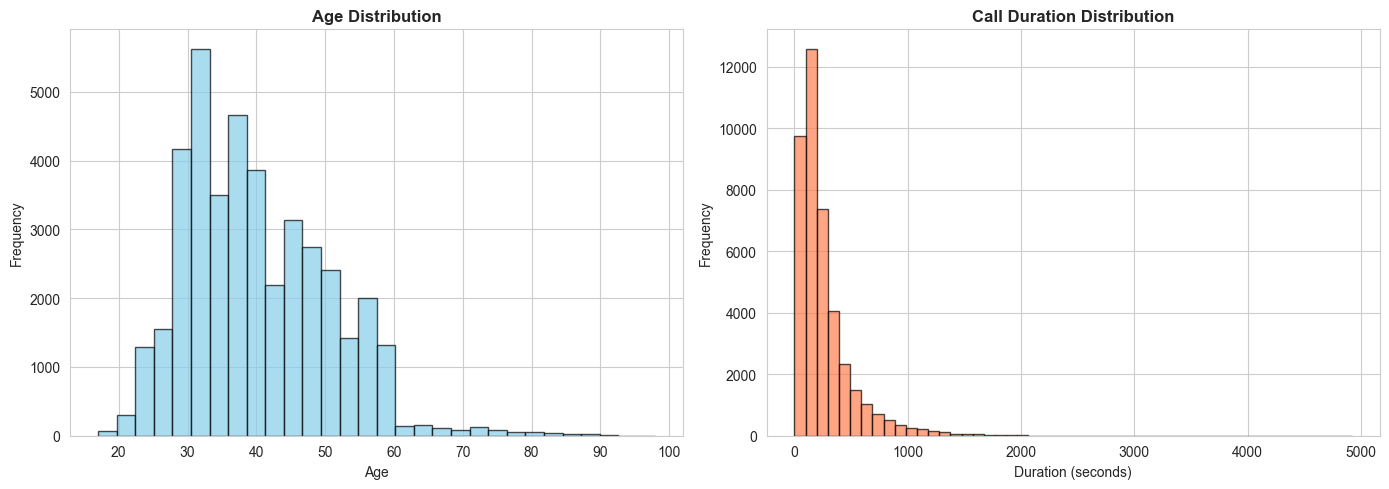

In [6]:
# Age and Duration distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Age Distribution', fontweight='bold')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_clean['duration'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Call Duration Distribution', fontweight='bold')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

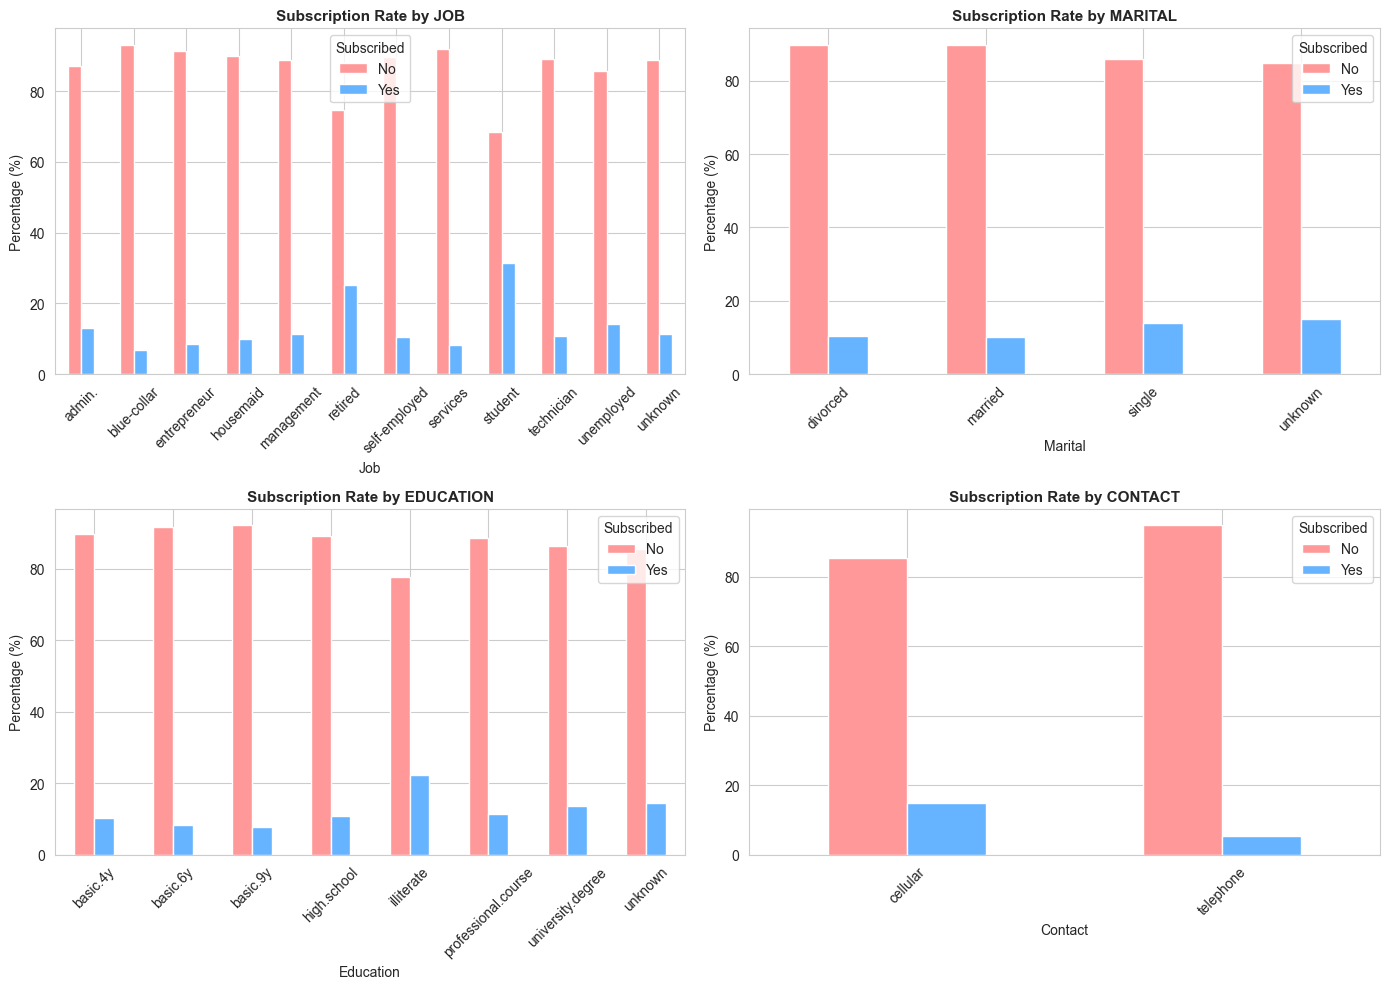

In [7]:
# Subscription rate by key features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

categorical_features = ['job', 'marital', 'education', 'contact']

for idx, col in enumerate(categorical_features):
    ct = pd.crosstab(df_clean[col], df_clean['y'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[idx], color=['#ff9999', '#66b3ff'])
    axes[idx].set_title(f'Subscription Rate by {col.upper()}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].legend(title='Subscribed', labels=['No', 'Yes'])
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

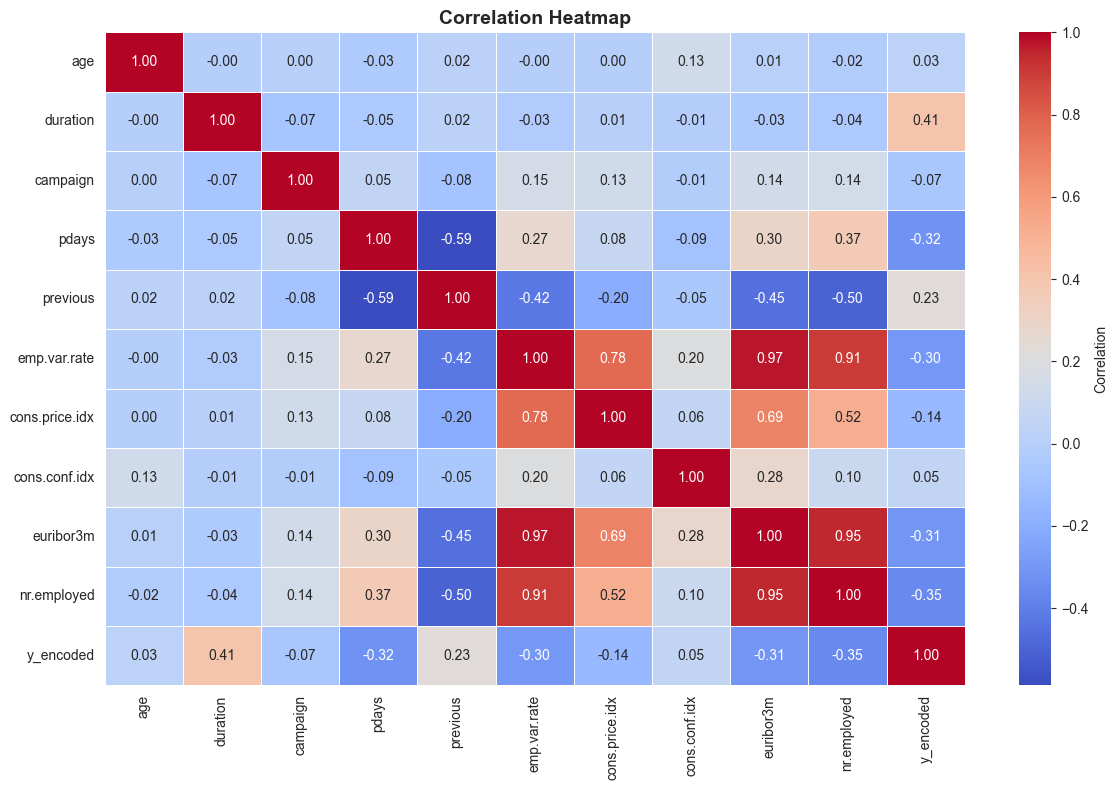


Top correlations with target:
y_encoded         1.000000
duration          0.405297
previous          0.230202
cons.conf.idx     0.054802
age               0.030381
campaign         -0.066361
cons.price.idx   -0.136134
emp.var.rate     -0.298289
euribor3m        -0.307740
pdays            -0.324948
nr.employed      -0.354669
Name: y_encoded, dtype: float64


In [8]:
# Correlation heatmap
df_corr = df_clean.copy()
df_corr['y_encoded'] = df_corr['y'].map({'yes': 1, 'no': 0})

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
corr_matrix = df_corr[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop correlations with target:")
print(corr_matrix['y_encoded'].sort_values(ascending=False))

## 5. Data Preprocessing

In [9]:
# Encode target
df_clean['y'] = df_clean['y'].map({'yes': 1, 'no': 0})

# Separate features and target
X = df_clean.drop('y', axis=1)
y = df_clean['y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (41176, 20)
Target shape: (41176,)


In [10]:
# Identify column types
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numerical columns (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Categorical columns (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [11]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

print("✅ Preprocessing pipeline created")
print("   - Numerical: StandardScaler")
print("   - Categorical: OneHotEncoder")

✅ Preprocessing pipeline created
   - Numerical: StandardScaler
   - Categorical: OneHotEncoder


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"\nTrain target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest target distribution:\n{y_test.value_counts(normalize=True)}")

Training set: (32940, 20)
Testing set: (8236, 20)

Train target distribution:
y
0    0.887341
1    0.112659
Name: proportion, dtype: float64

Test target distribution:
y
0    0.887324
1    0.112676
Name: proportion, dtype: float64


## 6. Model Training - Logistic Regression

In [13]:
# Create and train model
print("🤖 Training Logistic Regression...")

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model.fit(X_train, y_train)

print("✅ Model trained successfully!")

🤖 Training Logistic Regression...
✅ Model trained successfully!


## 7. Model Evaluation

In [14]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print("📊 LOGISTIC REGRESSION PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)

📊 LOGISTIC REGRESSION PERFORMANCE
Accuracy:  0.9089
Precision: 0.6474
Recall:    0.4213
F1-Score:  0.5104
ROC-AUC:   0.9389


In [15]:
# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))


📋 Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7308
         Yes       0.65      0.42      0.51       928

    accuracy                           0.91      8236
   macro avg       0.79      0.70      0.73      8236
weighted avg       0.90      0.91      0.90      8236



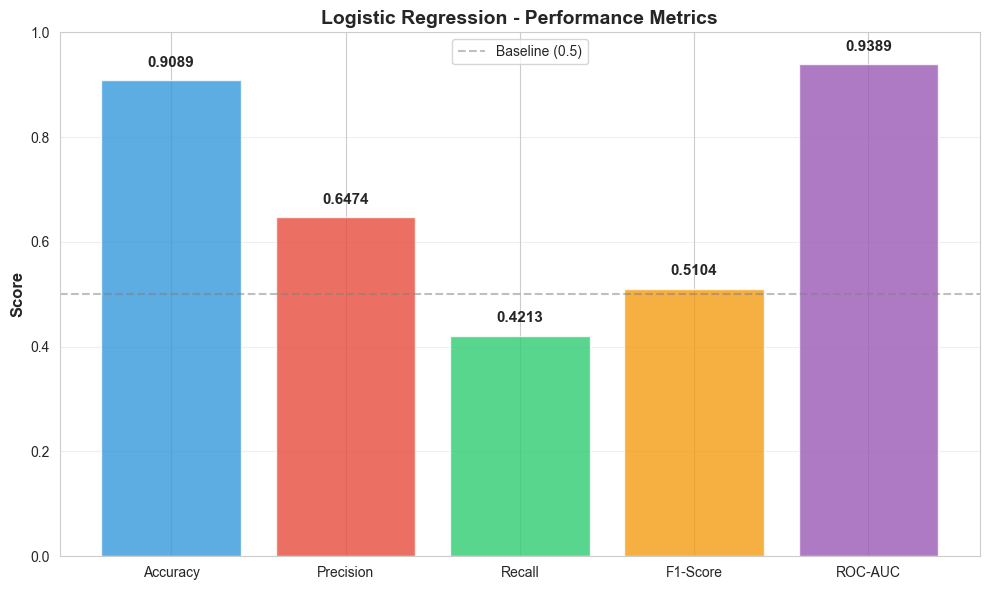

In [16]:
# Metrics Visualization
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'], alpha=0.8)
plt.ylim(0, 1.0)
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - Performance Metrics', fontsize=14, fontweight='bold')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.5)')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Metrics Summary Table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc],
    'Interpretation': [
        'Overall correctness of predictions',
        'Accuracy of positive predictions',
        'Coverage of actual positive cases',
        'Harmonic mean of Precision & Recall',
        'Model discrimination ability'
    ]
})

print("\n📊 DETAILED METRICS SUMMARY")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80)


📊 DETAILED METRICS SUMMARY
   Metric    Score                      Interpretation
 Accuracy 0.908936  Overall correctness of predictions
Precision 0.647351    Accuracy of positive predictions
   Recall 0.421336   Coverage of actual positive cases
 F1-Score 0.510444 Harmonic mean of Precision & Recall
  ROC-AUC 0.938935        Model discrimination ability


In [18]:
# Cross-validation score
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\n🔄 Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


🔄 Cross-Validation ROC-AUC Scores: [0.93676442 0.93334697 0.9332204  0.93493443 0.93441957]
Mean CV ROC-AUC: 0.9345 (+/- 0.0013)


## 8. Visualizations

<Figure size 800x600 with 0 Axes>

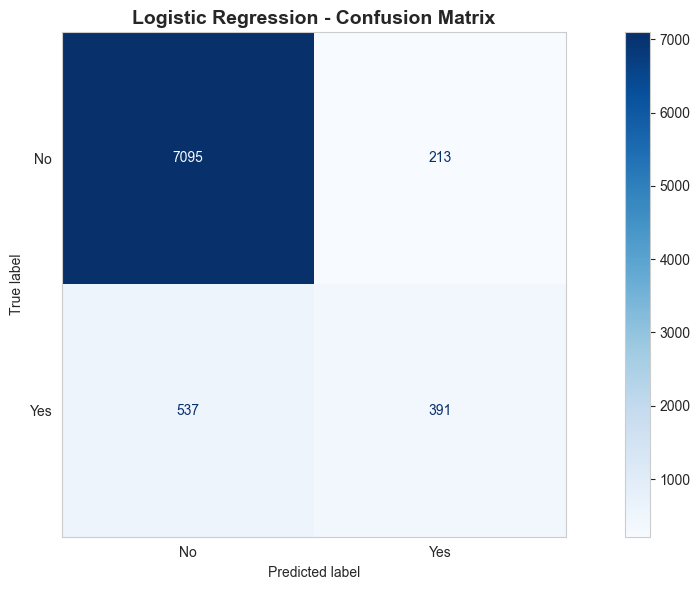


Confusion Matrix:
True Negatives:  7095
False Positives: 213
False Negatives: 537
True Positives:  391


In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

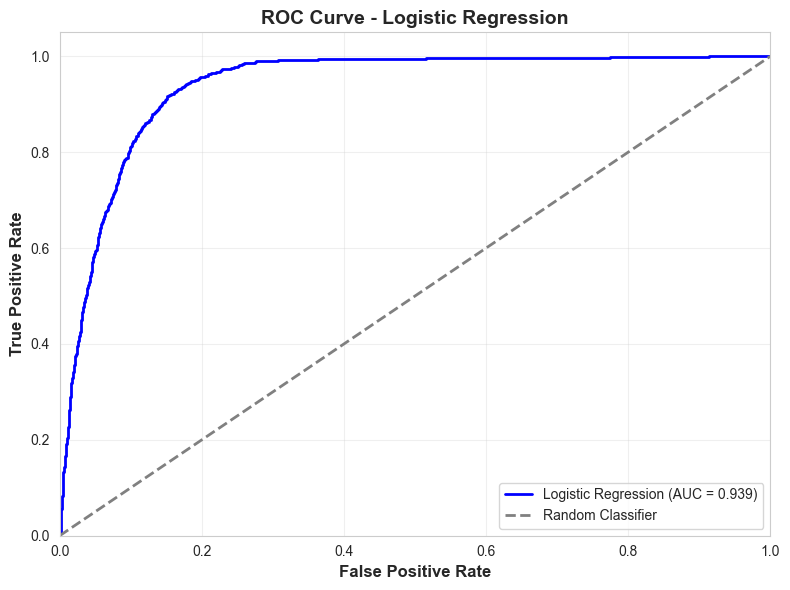

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

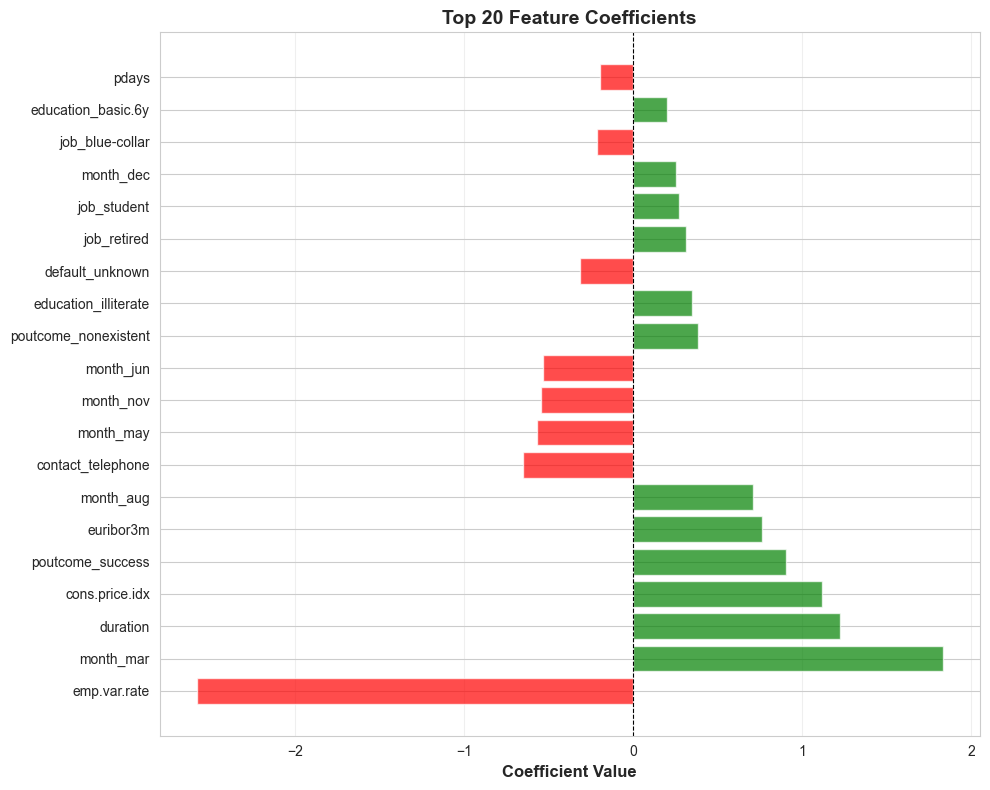


Top 10 Positive Coefficients (Increase subscription probability):
                 Feature  Coefficient
42             month_mar     1.830914
1               duration     1.221438
6         cons.price.idx     1.115466
52      poutcome_success     0.904209
8              euribor3m     0.759329
38             month_aug     0.706995
51  poutcome_nonexistent     0.381300
27  education_illiterate     0.347260
14           job_retired     0.313565
17           job_student     0.274276

Top 10 Negative Coefficients (Decrease subscription probability):
              Feature  Coefficient
5        emp.var.rate    -2.579545
37  contact_telephone    -0.651038
43          month_may    -0.566300
44          month_nov    -0.542421
41          month_jun    -0.534919
31    default_unknown    -0.314395
10    job_blue-collar    -0.210633
3               pdays    -0.196551


In [21]:
# Feature Coefficients
cat_transformer = model.named_steps['preprocessor'].transformers_[1][1]
cat_feature_names = cat_transformer.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_feature_names)

coefficients = model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(coef_df)), coef_df['Feature'])
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.title('Top 20 Feature Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Positive Coefficients (Increase subscription probability):")
print(coef_df[coef_df['Coefficient'] > 0].head(10))
print("\nTop 10 Negative Coefficients (Decrease subscription probability):")
print(coef_df[coef_df['Coefficient'] < 0].head(10))

## 9. Prediction Example

In [22]:
# Create sample customer data
sample_customer = pd.DataFrame({
    'age': [35],
    'job': ['admin.'],
    'marital': ['married'],
    'education': ['university.degree'],
    'default': ['no'],
    'housing': ['yes'],
    'loan': ['no'],
    'contact': ['cellular'],
    'month': ['may'],
    'day_of_week': ['mon'],
    'duration': [300],
    'campaign': [2],
    'pdays': [999],
    'previous': [0],
    'poutcome': ['nonexistent'],
    'emp.var.rate': [1.1],
    'cons.price.idx': [93.994],
    'cons.conf.idx': [-36.4],
    'euribor3m': [4.857],
    'nr.employed': [5191.0]
})

print("📋 Sample Customer Profile:")
print("="*60)
for col, val in sample_customer.iloc[0].items():
    print(f"{col:20s}: {val}")
print("="*60)

📋 Sample Customer Profile:
age                 : 35
job                 : admin.
marital             : married
education           : university.degree
default             : no
housing             : yes
loan                : no
contact             : cellular
month               : may
day_of_week         : mon
duration            : 300
campaign            : 2
pdays               : 999
previous            : 0
poutcome            : nonexistent
emp.var.rate        : 1.1
cons.price.idx      : 93.994
cons.conf.idx       : -36.4
euribor3m           : 4.857
nr.employed         : 5191.0



🔮 PREDICTION RESULTS
Prediction: ❌ NO - Will Not Subscribe

Probabilities:
  No (0):  0.9607 (96.07%)
  Yes (1): 0.0393 (3.93%)


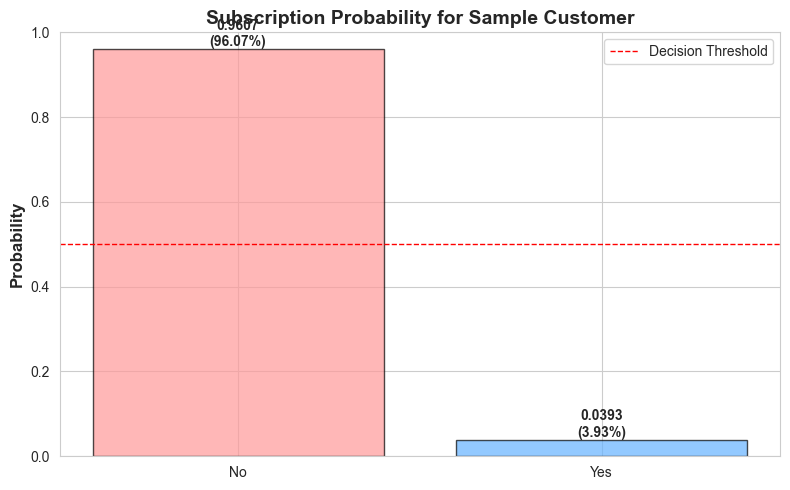

In [23]:
# Make prediction
prediction = model.predict(sample_customer)[0]
probability = model.predict_proba(sample_customer)[0]

print("\n🔮 PREDICTION RESULTS")
print("="*60)
print(f"Prediction: {'✅ YES - Will Subscribe' if prediction == 1 else '❌ NO - Will Not Subscribe'}")
print(f"\nProbabilities:")
print(f"  No (0):  {probability[0]:.4f} ({probability[0]*100:.2f}%)")
print(f"  Yes (1): {probability[1]:.4f} ({probability[1]*100:.2f}%)")
print("="*60)

# Visualize probability
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#ff9999', '#66b3ff']
bars = ax.bar(['No', 'Yes'], probability, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Probability', fontweight='bold', fontsize=12)
ax.set_title('Subscription Probability for Sample Customer', fontweight='bold', fontsize=14)
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Decision Threshold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}\n({height*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.legend()
plt.tight_layout()
plt.show()

In [24]:
# Batch prediction example with multiple customers
batch_customers = pd.DataFrame({
    'age': [25, 45, 60],
    'job': ['student', 'admin.', 'retired'],
    'marital': ['single', 'married', 'married'],
    'education': ['university.degree', 'high.school', 'basic.4y'],
    'default': ['no', 'no', 'no'],
    'housing': ['no', 'yes', 'yes'],
    'loan': ['no', 'no', 'no'],
    'contact': ['cellular', 'cellular', 'telephone'],
    'month': ['may', 'jul', 'aug'],
    'day_of_week': ['thu', 'tue', 'mon'],
    'duration': [180, 350, 120],
    'campaign': [1, 2, 3],
    'pdays': [999, 999, 999],
    'previous': [0, 1, 0],
    'poutcome': ['nonexistent', 'success', 'nonexistent'],
    'emp.var.rate': [1.1, 1.4, -0.1],
    'cons.price.idx': [93.994, 94.465, 93.200],
    'cons.conf.idx': [-36.4, -41.8, -42.0],
    'euribor3m': [4.857, 4.959, 1.313],
    'nr.employed': [5191.0, 5228.1, 5099.1]
})

batch_predictions = model.predict(batch_customers)
batch_probabilities = model.predict_proba(batch_customers)[:, 1]

results_df = batch_customers[['age', 'job', 'education', 'duration']].copy()
results_df['Prediction'] = ['Yes' if p == 1 else 'No' for p in batch_predictions]
results_df['Probability_Yes'] = batch_probabilities

print("\n📊 BATCH PREDICTION RESULTS (3 Customers)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


📊 BATCH PREDICTION RESULTS (3 Customers)
 age     job         education  duration Prediction  Probability_Yes
  25 student university.degree       180         No         0.036394
  45  admin.       high.school       350         No         0.187141
  60 retired          basic.4y       120         No         0.009067


## 10. Key Insights & Recommendations

In [25]:
print("="*80)
print("🔍 LOGISTIC REGRESSION - KEY INSIGHTS")
print("="*80)

print("\n1️⃣ MODEL PERFORMANCE:")
print(f"   - ROC-AUC Score: {roc_auc:.4f}")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Model is {'well-calibrated' if 0.7 <= roc_auc <= 0.85 else 'needs tuning'}")

print("\n2️⃣ TOP POSITIVE FEATURES (Increase subscription):")
top_positive = coef_df[coef_df['Coefficient'] > 0].head(5)
for idx, row in top_positive.iterrows():
    print(f"   ✅ {row['Feature']}: {row['Coefficient']:.4f}")

print("\n3️⃣ TOP NEGATIVE FEATURES (Decrease subscription):")
top_negative = coef_df[coef_df['Coefficient'] < 0].head(5)
for idx, row in top_negative.iterrows():
    print(f"   ❌ {row['Feature']}: {row['Coefficient']:.4f}")

print("\n4️⃣ BUSINESS RECOMMENDATIONS:")
print("   📞 Focus on longer call durations - strong positive predictor")
print("   📱 Prioritize cellular contact over telephone")
print("   📊 Target customers based on economic indicators")
print("   🎯 Use probability scores to prioritize high-likelihood prospects")

print("\n5️⃣ MODEL STRENGTHS:")
print("   ✅ Interpretable - coefficients show feature impact")
print("   ✅ Fast training and prediction")
print("   ✅ Provides probability estimates")
print("   ✅ Good baseline for comparison with complex models")

print("\n" + "="*80)

🔍 LOGISTIC REGRESSION - KEY INSIGHTS

1️⃣ MODEL PERFORMANCE:
   - ROC-AUC Score: 0.9389
   - Accuracy: 0.9089
   - F1-Score: 0.5104
   - Model is needs tuning

2️⃣ TOP POSITIVE FEATURES (Increase subscription):
   ✅ month_mar: 1.8309
   ✅ duration: 1.2214
   ✅ cons.price.idx: 1.1155
   ✅ poutcome_success: 0.9042
   ✅ euribor3m: 0.7593

3️⃣ TOP NEGATIVE FEATURES (Decrease subscription):
   ❌ emp.var.rate: -2.5795
   ❌ contact_telephone: -0.6510
   ❌ month_may: -0.5663
   ❌ month_nov: -0.5424
   ❌ month_jun: -0.5349

4️⃣ BUSINESS RECOMMENDATIONS:
   📞 Focus on longer call durations - strong positive predictor
   📱 Prioritize cellular contact over telephone
   📊 Target customers based on economic indicators
   🎯 Use probability scores to prioritize high-likelihood prospects

5️⃣ MODEL STRENGTHS:
   ✅ Interpretable - coefficients show feature impact
   ✅ Fast training and prediction
   ✅ Provides probability estimates
   ✅ Good baseline for comparison with complex models

